# Markov Random Fields
## An image de-noising example

Removing noise from a binary image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from numpy.random import seed, random

In [2]:
from numba import jit

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
img = imread("img.jpeg", as_gray=True)
img_shape = img.shape
img = np.round(img)

Let $\{y_i\}_i$ be the pixels of an observed noisy image. We suppose that the noisy image was generated using a noise-free image with pixels $\{x_i\}_i$ and randomly flippning the signs of the pixel with some small probability

In [5]:
final_noisy = np.copy(img)
# p(flip) = 0.1
mmap = random(size=(img_shape)) <= 0.1
final_noisy[mmap] = np.abs(final_noisy[mmap] - 1)

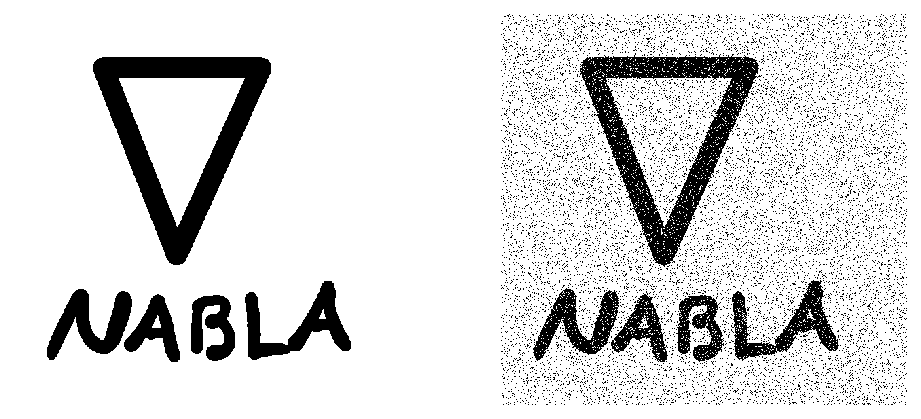

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(img, cmap="bone")
ax[1].imshow(final_noisy, cmap="bone")
ax[0].axis("off")
ax[1].axis("off");

Our energy function is given by
$$
    E({\bf x}, {\bf y}) = h\sum_ix_i - \beta \sum_{\{i,j\}}x_ix_j - \eta\sum_ix_iy_i 
$$

In [7]:
y = img.copy() * 2 - 1
x = img.copy() * 2 - 1

In [8]:
from numba import jit

In [9]:
def find_neighbors(x, i, j):
    nx, ny = x.shape
    neighbors = np.array([(i, j + 1), (i + 1, j),
                          (i - 1, j), (i, j - 1)])
    filter1 = ~(neighbors < 0).any(axis=1)
    filter2 = ~(neighbors >= np.array(x.shape)).any(axis=1)
    filter_final = filter1 & filter2
    return neighbors[filter_final].T

@jit(nopython=True)
def E(x, y, h=0, beta=0.1, eta=2.1):
    total_energy = h * x.sum() - eta * (x * y).sum()
    total_energy = 0
    nx, ny = x.shape
    for i in range(nx):
        for j in range(ny):
            # neighbors_ix = find_neighbors(x, i, j)
            rows, cols = [], []
            if i > 0:
                rows.append(i - 1)
                cols.append(j)
            if j > 0:
                rows.append(i)
                cols.append(j - 1)
            if i < nx-1:
                rows.append(i + 1)
                cols.append(j)
            if j < ny-1:
                rows.append(i)
                cols.append(j + 1)
                
            neighbor_energy = 0.
            for row, col in zip(rows, cols):
                neighbor_energy += beta * x[row, col] * x[i, j]
            
            #neighbors = x[rows, cols]
            #neighbor_energy = (neighbors * x[i, j]).sum()
            total_energy = total_energy + neighbor_energy
            
    return total_energy

In [ ]:
for i in range(nx):
    for j in range(ny):
        
        x[i,j] = 1
        energy_plus = E(x, y)
        
        x[i,j] = -1
        energy_minus = E(x, y)
        
        if energy_plus < energy_minus:
            x[i,j] = 1
        else:
            x[i,j] = -1

In [21]:
@jit(nopython=True)
def update_pixels(x, y):
    nx, ny = x.shape
    x = x.copy()
    for i in range(nx):
        for j in range(ny):
            if nx * ny % 10 == 0:
                print("({i},{j})/({nx}, {ny})")

            x[i,j] = 1
            energy_plus = E(x, y)

            x[i,j] = -1
            energy_minus = E(x, y)

            if energy_plus < energy_minus:
                x[i,j] = 1
            else:
                x[i,j] = -1
    return x

In [22]:
%%time
E(x, y)

CPU times: user 317 ms, sys: 1.79 ms, total: 319 ms
Wall time: 319 ms


135715.5999991449

In [ ]:
%%time
res = update_pixels(x, y)

In [186]:
rows, cols = neighbors.T

In [187]:
rows

array([574, 575])